In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from scipy.spatial.distance import cdist
from datetime import datetime
from pytz import timezone

from sklearn.preprocessing import minmax_scale

import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
full_history = pd.read_json('data/history_clean.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))

In [3]:
artists = pd.read_json('data/artists_clean.json')

In [4]:
def get_unique():
    unique_history = full_history.drop(['hour_decimal', 'weekday', 'timestamp'], axis=1)
    return unique_history.drop_duplicates('id')

## Do I prefer to discover new music or stick with known songs?

Do I have any go-to songs? artists? A go-to song is a song...

Do I have any hidden favorite songs? artists?

How much of my collection is from artists from my list of top artists?

The top 1% of artists ($n=40$) make up 27% of songs in my history, the top 5% of artists ($n=201$) make up 52% of songs, the top 10% of artists ($n=403$) make up 66% of songs, and the top 25% of artists ($n=1007$) make up 82% of songs.

In [16]:
makeup = []
brackets = [0.01, 0.05, 0.1, 0.25]

sort_artist_df = artists.sort_values('listens', ascending=False)

fh_a = full_history['artists'].values

for portion in brackets:
    
    top_portion = int(len(sort_artist_df) * portion)
    top_portion = sort_artist_df.iloc[:top_portion, 3].values
        
    total_songs_in_portion = 0.0
    for row in fh_a:
        # for each track, look through the artists
        for artist in list(row):
            # if at least one artist on the song is in the top portion, count it and skip the rest
            if artist in top_portion:
                total_songs_in_portion += 1                
                break
    makeup.append([len(top_portion), total_songs_in_portion / len(full_history)])
    
makeup = np.array(makeup)

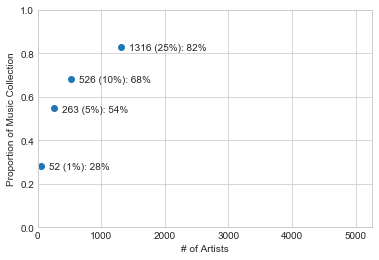

In [23]:
plt.scatter(x=makeup[:, 0], y=makeup[:, 1])

for i, elm in enumerate(makeup):
    plt.annotate('{} ({}%): {}%'.format(int(elm[0]), int(brackets[i]*100), int(elm[1]*100)), 
                 (elm[0], elm[1]), (elm[0]+120, elm[1]-0.015))

plt.xlabel('# of Artists')
plt.ylabel('Proportion of Music Collection')
plt.xlim([0,len(artists)])
plt.ylim([0,1]);

54.0% of artists I've listened to, I've only listened to once!

In [24]:
len(sort_artist_df[sort_artist_df['listens'] == 1]) / len(sort_artist_df)

0.5396011396011396

# Is my music collection mainstream?

Compared to what most people are listening to, am I any different? (I'd like to think so, but we'll see)

## How *pop*-y is my music?

First, is my music similar to popular music is my collection? We compare my music to Spotify's two playlists: 

In [25]:
mainstream = pd.read_json('data/mainstream_music.json')

In [26]:
mainstream['tempo'] = mainstream['tempo'].apply(round)
mainstream['tempo'] = mainstream['tempo'].apply(lambda x: x if x < 168 else x/2)

mainstream['duration'] = mainstream['duration_ms'] / 1000 / 60
mainstream = mainstream.drop('duration_ms', axis=1)

$p<0.01$

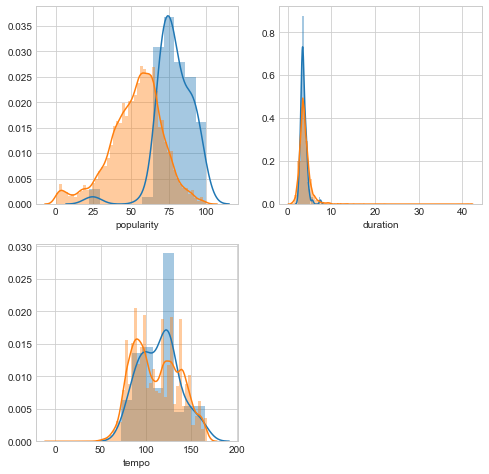

In [28]:
plt.subplots(figsize=(8,8))

plt.subplot(221)
sns.distplot(mainstream['popularity'])
sns.distplot(full_history['popularity'])

plt.subplot(222)
sns.distplot(mainstream['duration'])
sns.distplot(full_history['duration'])

plt.subplot(223)
sns.distplot(mainstream['tempo'])
sns.distplot(full_history['tempo'])

In [29]:
stats.ttest_ind(mainstream['popularity'], full_history['popularity'], 0, False)

Ttest_indResult(statistic=20.121111178042838, pvalue=1.9843042968950007e-36)

In [30]:
stats.ttest_ind(mainstream['duration'], full_history['duration'], 0, False)

Ttest_indResult(statistic=-3.4882599553977101, pvalue=0.00072508521853550955)

In [31]:
stats.ttest_ind(mainstream['tempo'], full_history['tempo'], 0, False)

Ttest_indResult(statistic=1.5337542004386184, pvalue=0.1283644948835603)

number of genres, number of songs in genre, number of artists, number of individual days listened


A lot of us claim we listen to a "diverse" range of music. Some people say they listen to everything. I've been trying to think about what it means for a music collection to be diverse and wanted to get some opinions...

Diversity may be a measure of:

- the variety of instruments (i.e. if a person's music collection is all blues guitar, is it still diverse? What if it ranges from country to metal?)

- Number of genres (seems to be popular). If someone listens to classical, rock, EDM, rap, are they diverse listeners?

- How do we consider international musics? If the above point is true, what about Afrobeat or Bhangra or Celtic folk? Is a person's music collection truly diverse if it doesn't have elements from around the globe?

- We might agree that a person can listen to a variety of bands, but if that person can only name a single song from a band they claim to be a "fan" of, do we believe their music is still diverisfied? How much does a person need to invest in their music for it to be diverse?

Eventually, it might get to the point where listening to everything is actually enjoying nothing. How much "liking" or listening is necessary to be a fan?

With this in mind, how can we quanitify variety?

don't really know how different things can be, so measure similarity instead?

In [128]:
select_features = ['acousticness', 'danceability', 'energy', 'explicit', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'time_signature', 'valence', 'duration']

num_mat = mainstream[select_features]
 
num_mat = minmax_scale(num_mat, (-1, 1), 0)

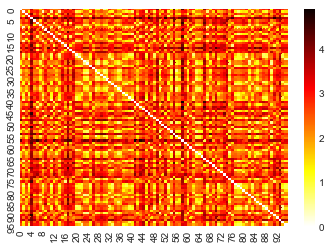

In [129]:
Y = cdist(num_mat, num_mat, 'euclidean')

sns.heatmap(Y, vmin=0.0, cmap='hot_r')

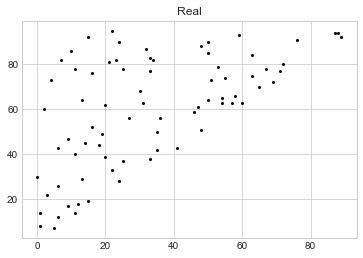

In [130]:
sort_Y = Y.argsort(axis=1)
unique_sort_Y = np.unique(np.sort(sort_Y[:, 0:2], axis=1), axis=0)
plt.title('Real')
plt.scatter(unique_sort_Y[:, 0], unique_sort_Y[:, 1], c='k', s=4);

In [131]:
ds = []
indices = []

for pair in unique_sort_Y:
    ds.append(Y[pair[0], pair[1]])
        
    indices.append(list(pair))
    
    if pair[0] < 5:
        print('distance: {}\t({},{})'.format(Y[pair[0], pair[1]], pair[0], pair[1]))
        print(mainstream.loc[pair])

indices = np.array(indices)

distance: 0.61981964538445	(0,30)
    acousticness      album                   artists  danceability  energy  \
0         0.0291  The Heist  [5BcAKTbp20cv7tC5VqPFoC]         0.641   0.922   
30        0.0384       MKTO  [2l35CQqtYRh3d8ZIiBep4v]         0.720   0.791   

    explicit                      id  key  liveness  loudness  mode  \
0          0  3bidbhpOYeV4knp8AIu8Xn    2    0.0862    -4.457     1   
30         0  6FE2iI43OZnszFLuLtvvmg    1    0.1570    -4.689     1   

                                name  popularity     release  speechiness  \
0   Can't Hold Us - feat. Ray Dalton          83  2012-10-09       0.0786   
30                           Classic          77        2012       0.1240   

    tempo  time_signature  valence  duration  
0   146.0               4    0.847  4.305717  
30  102.0               4    0.756  2.923783  
distance: 0.36041212725859306	(1,8)
   acousticness                      album  \
1        0.0991                  Wild Ones   
8        0.10

Mean Standardized Euclidean similarity coefficient: 0.929
0.411525259739


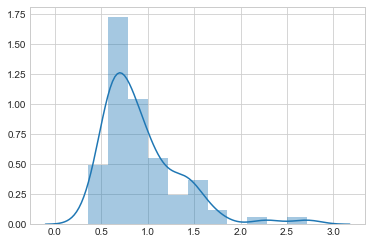

In [132]:
sns.distplot(ds, kde=True)
print('Mean Standardized Euclidean similarity coefficient: {:.3f}'.format(np.array(ds).mean()))
print(np.array(ds).std())

In [133]:
select_features = ['acousticness', 'danceability', 'energy', 'explicit', 'log_loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'time_signature', 'valence', 'duration']

u = get_unique()

num_mat = u[select_features]
 
num_mat = minmax_scale(num_mat, (-1, 1), 0)

In [19]:
v = np.array(u['genres'].values)
v = v[v != None]

g, c = np.unique(list(itertools.chain.from_iterable(v)), return_counts=True)
ngenres = pd.DataFrame({'genre': g, 'count': c}).nlargest(75, 'count')

In [20]:
def simplifyGenre(x):
    for genre in ngenres['genre']:
        if genre in x:
            return genre
        
    return 'other'

u['simple_genre'] = u['genres'].dropna().apply(simplifyGenre)

In [ ]:
np.unique(u['simple_genre'].dropna(), return_counts=True)

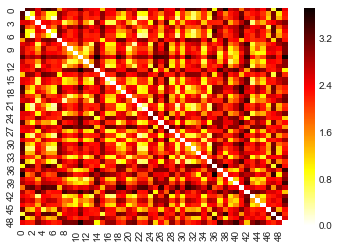

In [134]:
Y = cdist(num_mat, num_mat, 'euclidean')

sns.heatmap(Y[:50, :50], cmap='hot_r')

In [135]:
sort_Y = Y.argsort(axis=1)

In [136]:
unique_sort_Y = np.unique(np.sort(sort_Y[:, 0:2], axis=1), axis=0)

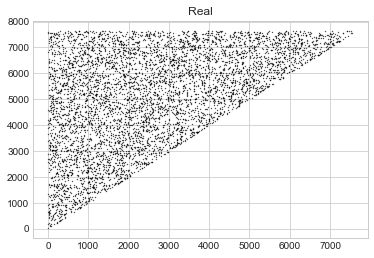

In [137]:
plt.title('Real')
plt.scatter(unique_sort_Y[:, 0], unique_sort_Y[:, 1], c='k', s=0.1)

In [138]:
ds = []
indices = []

for pair in unique_sort_Y:
    ds.append(Y[pair[0], pair[1]])
    
    indices.append(list(pair))
    
    if pair[0] < 3:
        print('distance: {}\t({},{})'.format(Y[pair[0], pair[1]], pair[0], pair[1]))
        print(u.iloc[pair])

indices = np.array(indices)

distance: 0.35433023363254246	(0,3906)
      acousticness                      album                   artists  \
0           0.0479                      DAMN.  [2YZyLoL8N0Wb9xBt1NhZWg]   
1539        0.0504  DAMN. COLLECTORS EDITION.  [2YZyLoL8N0Wb9xBt1NhZWg]   

      danceability  duration  energy  explicit  \
0            0.546   4.14355   0.728         1   
1539         0.547   4.14355   0.739         1   

                              genres                      id  key  \
0     [hip hop, rap, west coast rap]  0y9uTzK9cNKSAEHnpeRG8C    0   
1539  [hip hop, rap, west coast rap]  2PESSRrfGBuDrJ1I7rm8dc    1   

      log_loudness  mode        name  popularity  speechiness  tempo  \
0         2.067875     1  DUCKWORTH.          68        0.632   88.5   
1539      2.066610     1  DUCKWORTH.          53        0.718   88.0   

      time_signature  valence  
0                  4    0.639  
1539               4    0.618  
distance: 0.3312992491568288	(1,4185)
     acousticness        

Mean Standardized Euclidean similarity coefficient: 0.361
0.125130406411


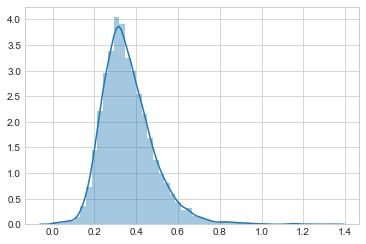

In [139]:
sns.distplot(ds, kde=True)
print('Mean Standardized Euclidean similarity coefficient: {:.3f}'.format(np.array(ds).mean()))
print(np.array(ds).std())